In [1]:
import matplotlib 
from matplotlib import pyplot as plt
import time

In [2]:
# Load MNIST data

import numpy as np
import gzip
import struct


def load_images(filename):
    # Open and unzip the file of images:
    with gzip.open(filename, 'rb') as f:
        # Read the header information into a bunch of variables:
        _ignored, n_images, columns, rows = struct.unpack('>IIII', f.read(16))
        # Read all the pixels into a NumPy array of bytes:
        all_pixels = np.frombuffer(f.read(), dtype=np.uint8)
        # Reshape the pixels into a matrix where each line is an image:
        return all_pixels.reshape(n_images, columns * rows)


# 60000 images, each 784 elements (28 * 28 pixels)
X_train = load_images("../data/mnist/train-images-idx3-ubyte.gz")

# 10000 images, each 784 elements, with the same structure as X_train
X_test = load_images("../data/mnist/t10k-images-idx3-ubyte.gz")


def load_labels(filename):
    # Open and unzip the file of images:
    with gzip.open(filename, 'rb') as f:
        # Skip the header bytes:
        f.read(8)
        # Read all the labels into a list:
        all_labels = f.read()
        # Reshape the list of labels into a one-column matrix:
        return np.frombuffer(all_labels, dtype=np.uint8).reshape(-1, 1)


def one_hot_encode(Y):
    n_labels = Y.shape[0]
    n_classes = 10
    encoded_Y = np.zeros((n_labels, n_classes))
    for i in range(n_labels):
        label = Y[i]
        encoded_Y[i][label] = 1
    return encoded_Y


# !!! EDIT PATHS TO WHERE YOUR MNIST DATA IS !!!

# 60K labels, each a single digit from 0 to 9
Y_train_unencoded = load_labels("../data/mnist/train-labels-idx1-ubyte.gz")

# 60K labels, each consisting of 10 one-hot encoded elements
Y_train = one_hot_encode(Y_train_unencoded)

# 10000 labels, each a single digit from 0 to 9
Y_test = load_labels("../data/mnist/t10k-labels-idx1-ubyte.gz")

In [3]:
# A neural network implementation (almost the same as backpropagation.py,
# except for a tiny refactoring in the back() function).

import numpy as np


def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def softmax(logits):
    exponentials = np.exp(logits)
    return exponentials / np.sum(exponentials, axis=1).reshape(-1, 1)


def sigmoid_gradient(sigmoid):
    return np.multiply(sigmoid, (1 - sigmoid))


def loss(Y, y_hat):
    return -np.sum(Y * np.log(y_hat)) / Y.shape[0]


def prepend_bias(X):
    return np.insert(X, 0, 1, axis=1)


def forward(X, w1, w2):
    h = sigmoid(np.matmul(prepend_bias(X), w1))
    y_hat = softmax(np.matmul(prepend_bias(h), w2))
    return (y_hat, h)


def back(X, Y, y_hat, w2, h):
    w2_gradient = np.matmul(prepend_bias(h).T, (y_hat - Y)) / X.shape[0]
    w1_gradient = np.matmul(prepend_bias(X).T, np.matmul(y_hat - Y, w2[1:].T)
                            * sigmoid_gradient(h)) / X.shape[0]
    return (w1_gradient, w2_gradient)


def classify(X, w1, w2):
    y_hat, _ = forward(X, w1, w2)
    labels = np.argmax(y_hat, axis=1)
    return labels.reshape(-1, 1)


def initialize_weights(n_input_variables, n_hidden_nodes, n_classes):
    w1_rows = n_input_variables + 1
    w1 = np.random.randn(w1_rows, n_hidden_nodes) * np.sqrt(1 / w1_rows)

    w2_rows = n_hidden_nodes + 1
    w2 = np.random.randn(w2_rows, n_classes) * np.sqrt(1 / w2_rows)

    return (w1, w2)


def report(iteration, X_train, Y_train, X_test, Y_test, w1, w2):
    y_hat, _ = forward(X_train, w1, w2)
    training_loss = loss(Y_train, y_hat)
    classifications = classify(X_test, w1, w2)
    accuracy = np.average(classifications == Y_test) * 100.0
    print("Iteration: %5d, Loss: %.8f, Accuracy: %.2f%%" %
          (iteration, training_loss, accuracy))
    return accuracy, training_loss
    

def train(X_train, Y_train, X_test, Y_test, n_hidden_nodes, iterations, lr):
    start_time = time.time()
    success_rates = []
    losses = []
    times = []
    n_input_variables = X_train.shape[1]
    n_classes = Y_train.shape[1]
    w1, w2 = initialize_weights(n_input_variables, n_hidden_nodes, n_classes)
    for iteration in range(iterations):
        y_hat, h = forward(X_train, w1, w2)
        w1_gradient, w2_gradient = back(X_train, Y_train, y_hat, w2, h)
        w1 = w1 - (w1_gradient * lr)
        w2 = w2 - (w2_gradient * lr)
        accuracy, training_loss = report(iteration, X_train, Y_train, X_test, Y_test, w1, w2)
        success_rates.append(accuracy)
        losses.append(training_loss)
        times.append(time.time()-start_time)
    return (w1, w2, success_rates, losses, times)





In [23]:
# NEU: minibatch-Verfahren

def prepare_batches(X_train, Y_train, batchsize):
    x_batches = []
    y_batches = []
    n_examples = X_train.shape[0]
    for b in range(0, n_examples, batchsize):
        e = b + batchsize
        x_batches.append(X_train[b:e])
        y_batches.append(Y_train[b:e])
    return x_batches, y_batches


def train_minibatch(X_train, Y_train, X_test, Y_test, n_hidden_nodes, iterations, lr, batchsize):
    start_time = time.time()
    success_rates = []
    losses = []
    times = []
    success_rates_batches = []
    losses_batches = []    
    times_batches = []
    n_input_variables = X_train.shape[1]
    n_classes = Y_train.shape[1]
    w1, w2 = initialize_weights(n_input_variables, n_hidden_nodes, n_classes)
    x_batches, y_batches = prepare_batches(X_train, Y_train, batchsize)
    print('prepared %d batches'%len(x_batches))
    for iteration in range(iterations):
        if iteration >= 20:
            lr = 0.1
        if iteration >= 30:
            lr = 0.01
        if iteration >= 40:
            lr = 0.03
        for batch in range(len(x_batches)):
            y_hat, h = forward(x_batches[batch], w1, w2)
            w1_gradient, w2_gradient = back(x_batches[batch], y_batches[batch], y_hat, w2, h)
            w1 = w1 - (w1_gradient * lr)
            w2 = w2 - (w2_gradient * lr)
            accuracy, training_loss = report_minibatch(iteration, batch, X_train, Y_train, X_test, Y_test, w1, w2)
            success_rates_batches.append(accuracy)
            losses_batches.append(training_loss)
            times_batches.append(time.time()-start_time)
        success_rates.append(accuracy)
        losses.append(training_loss)
        times.append(time.time()-start_time)
    return (w1, w2, success_rates, losses, times, success_rates_batches, losses_batches, times_batches)


def report_minibatch(iteration, batch, X_train, Y_train, X_test, Y_test, w1, w2):
    y_hat, _ = forward(X_train, w1, w2)
    training_loss = loss(Y_train, y_hat)
    classifications = classify(X_test, w1, w2)
    accuracy = np.average(classifications == Y_test) * 100.0
    print("Iteration: %5d, batch: %3d, Loss: %.8f, Accuracy: %.2f%%" %
          (iteration, batch, training_los
           s, accuracy))
    return accuracy, training_loss

In [6]:
# create a dictionary to store your success rates
# !!! UNCOMMENT, EXECUTE, AND COMMENT AGAIN !!!
# !!! DON'T EXECUTE THE LINES AGAIN AFTER STARTING TO COLLECT RESULTS !!!

#success_rates = {}
#losses = {}
#times = {}


In [44]:
n_train = 60000 # number of examples in training data (max is 60,000)
n_test  = 10000 # number of examples in training data (max is 10,000)
n_nodes = 800 # number of hidden nodes
n_iters = 60 # number of iterations
lr      = 0.4
batchsize = 6000

# create a string with the parameter values
lr_str = str(lr).replace('.', 'p')
if 0: # no minibatches
    name = 'success_rates_train{}_test{}_nodes{}_iters{}_lr{}'.format(n_train, n_test, n_nodes, n_iters, lr_str) 
    (w1, w2, sr, ls, ts) = train(X_train[:n_train], Y_train[:n_train], 
                   X_test[:n_test], Y_test[:n_test], 
                   n_hidden_nodes=n_nodes, iterations=n_iters, lr=lr)
    success_rates[name] = sr # store results
    times[name] = ts

if 1: # with minibatches
    name_minibatch = 'success_rates_train{}_test{}_nodes{}_iters{}_lr{}_batchsize{}'.format(n_train, n_test, n_nodes, n_iters, lr_str, batchsize) 
    (w1, w2, sr, ls, ts, sr_batches, ls_batches, ts_batches) = train_minibatch(X_train[:n_train], Y_train[:n_train], 
                   X_test[:n_test], Y_test[:n_test], 
                   n_hidden_nodes=n_nodes, iterations=n_iters, lr=lr, batchsize = batchsize)
    success_rates[name_minibatch] = sr # store results
    times[name_minibatch] = ts

prepared 10 batches
Iteration:     0, batch:   0, Loss: 4.45881537, Accuracy: 14.62%


/var/folders/nb/r7d1zvcs4g5_lpdwx6rf5tgr0000gn/T/ipykernel_93577/150598522.py:8: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Iteration:     0, batch:   1, Loss: 6.38308384, Accuracy: 34.15%
Iteration:     0, batch:   2, Loss: 5.47114215, Accuracy: 33.24%
Iteration:     0, batch:   3, Loss: 3.34201066, Accuracy: 30.37%
Iteration:     0, batch:   4, Loss: 2.04720486, Accuracy: 31.41%
Iteration:     0, batch:   5, Loss: 1.44846423, Accuracy: 58.80%
Iteration:     0, batch:   6, Loss: 1.17634025, Accuracy: 68.54%
Iteration:     0, batch:   7, Loss: 1.00596319, Accuracy: 80.52%
Iteration:     0, batch:   8, Loss: 0.88004875, Accuracy: 81.41%
Iteration:     0, batch:   9, Loss: 0.79984928, Accuracy: 82.52%
Iteration:     1, batch:   0, Loss: 0.75709290, Accuracy: 80.70%
Iteration:     1, batch:   1, Loss: 0.74518193, Accuracy: 80.66%
Iteration:     1, batch:   2, Loss: 0.74182345, Accuracy: 80.06%
Iteration:     1, batch:   3, Loss: 0.72488151, Accuracy: 78.48%
Iteration:     1, batch:   4, Loss: 0.72066329, Accuracy: 79.71%
Iteration:     1, batch:   5, Loss: 0.66017952, Accuracy: 79.06%
Iteration:     1, batch: 

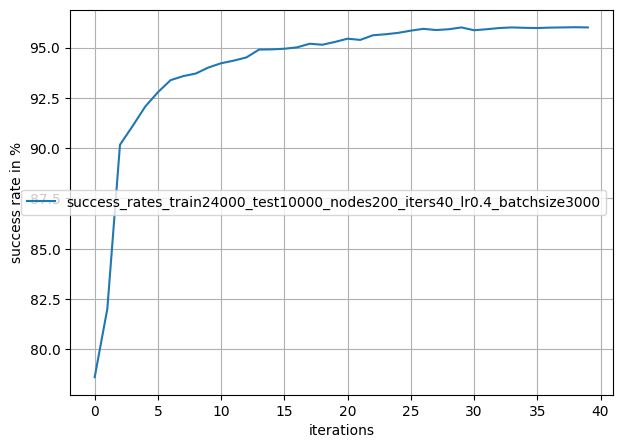

In [42]:
# Plot results as a function of ITERATIONS
#
# here you can plot several training curves alongside each other 
# uncomment, delete, edit, copy-paste lines correspondingly
# edit the NAME of the results to be plotted AND edit the LABEL, such that the legend is correct
plt.figure(figsize = (7,5))
plt.plot(success_rates['success_rates_train60000_test10000_nodes600_iters40_lr0p4_batchsize6000'], 
               label = 'success_rates_train24000_test10000_nodes200_iters40_lr0.4_batchsize3000')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('success rate in %')
plt.grid()
#plt.ylim([60,95]) # uncomment line to restrict the y-range for more detailed view on the late training

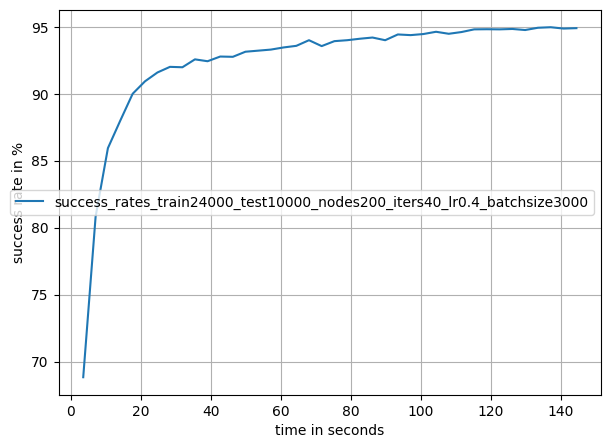

In [43]:
# plot results as a function of TIME

plt.figure(figsize = (7,5))
plt.plot(        times['success_rates_train60000_test10000_nodes400_iters40_lr0p4_batchsize6000'], 
         success_rates['success_rates_train24000_test10000_nodes200_iters40_lr0p4_batchsize3000'], 
               label = 'success_rates_train24000_test10000_nodes200_iters40_lr0.4_batchsize3000')
plt.legend()
plt.xlabel('time in seconds')
plt.ylabel('success rate in %')
plt.grid()
#plt.ylim([80,95]) # uncomment line to restrict the y-range for more detailed view on the late training